### Time To Event Forecasting with Simple ML Approaches

In data-driven companies, **time-to-event** applications assume a crucial role in decision-making (also more than we can imagine). **With time-to-event analysis, we are referring to all the techniques used to measure the time which elapses until some events of interest happen.** 
This straight-forward definition may immediately outline all the benefits of developing time-event applications in business contexts (and not only). 

Time-to-event origins are related to the medical field to answer questions like: "how long do the individuals under analysis live?". For this reason, the terms survival and time-to-event are usually used as synonyms. Nowadays, **with the adoption of machine learning on large scale, it's usual to find applications of survival methodologies** also in companies outside the medical/clinical sector. A manufacturer may be interested in estimating the expected life of some engines; a service provider may need to compute the expected life of their customers; a financial institution may evaluate the borrower's insolvency risk over time. 

**Practically speaking, to model a time-to-event problem, there is a proper set of methodologies.** From classical linear statistical methods to more sophisticated machine learning approaches up to cutting-edge deep-learning solutions, a lot of **survival frameworks** have been released. All of them are awesomebut they must respect the assumption proper to the survival modeling theory which may result in low adaptability or limitations for real use cases. For these reasons, **a convinient way to deal with survival analysis may consist of treating time-to-event modeling as a classification problem.**

In this article, we propose a generalization to carry out survival analysis with predictive capabilities. **We aim to model the elapsed time, between the starting time and the event of interest, as a multiple binary classification problem.** With proper and simple post-processing, we can retrieve reliable and robust individual survival curves. **We can do it using our favorite classification algorithm**, making parameters search as always, and considering the posiibility to calibrate our outcomes to make them more trustable. 


### THE DATA

Arranging the data at our disposal to implement a survival predictive application is particularly sraightforward and does not require particular effort. We must have some input features (numerical or categorical) and a raw target, like in a standard regression/classification tabular task. In this context, **the target represents how much time elapsed from the monitoring start to the event happening.**

Let's imagine being a company that offers an online subscription service. We may be interested in computing the expected life of our customers at subscription time. In other words, when a new customer lands on our platform and subscribes to get the services, we would like to know how much time she/he will remain out client. We can carry out the task by developing a survival approach that outputs probability survival curves (one for each customer). **Survival curves are sequences of monotonic probabilities.** For each time step, we have numbers between 0 and 1 that state the survival likelihood of some events (subscription in our case) in that particular time range. 

A graphical representation of survival function<br>
<img src='https://miro.medium.com/max/720/1*Pj8AbRVb3U1OQcr51k-kwg.webp'>



We simulate some numerical input features and a target representing how much time individuals remain our customers from their first subscription. From our simulation, we observe that most of our customers leave in the first stage after their engagement (left side of histogram below). This represents a reliable dynamic for most companies, where a lot of clients churn after a while. On the contrary, we have a group of loyal subscribers who remain users of our services. In our case, we limit the maximum observable subscription times up to 700 periods (let's say days). This assumption is mandatory to make our approach work. 

Event time distribution(on the left), Binary label proportion(on the right)<br>
<img src="https://miro.medium.com/max/720/0*Rfjhv8ZB5T3MbaMc.webp">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss

#### Simulating the Survival Data

In [2]:
def sim_event_times(n_samples=3_000, n_features=20, random_state=0):
    X, y = make_regression(
        n_samples = n_samples, n_features = n_features, 
        n_informative = int(n_features*.4), random_state = random_state,
    )
    y = np.searchsorted(np.quantile(y, np.linspace(0,1,10)), y)
    np.random.seed(random_state)
    betas = 365 * np.exp(-0.6 * y) / np.log(1.1)
    y_time = np.random.exponential(betas)
    return X, y_time

X, y_time = sim_event_times(n_samples=3_000, n_features=20)

#### Adjust Event Target

In [8]:
n_bins = 20
max_time = 700

y_time[(y_time > max_time)] = max_time
bin_edges = np.linspace(y_time.min(), y_time.max(), n_bins+1)
bin_edges[0] = 0

encoder = OneHotEncoder(
    categories = [np.arange(n_bins+1)],
    sparse = False, drop = None
).fit(np.zeros((1,1)))

time = np.searchsorted(bin_edges[1:], y_time, side='right')
y_time_ohe = encoder.transform(time.reshape(-1,1))
y_time_ohe = np.cumsum(y_time_ohe, 1)
y_time_ohe = y_time_ohe[:, :-1]
y_time_ohe.shape

(3000, 20)

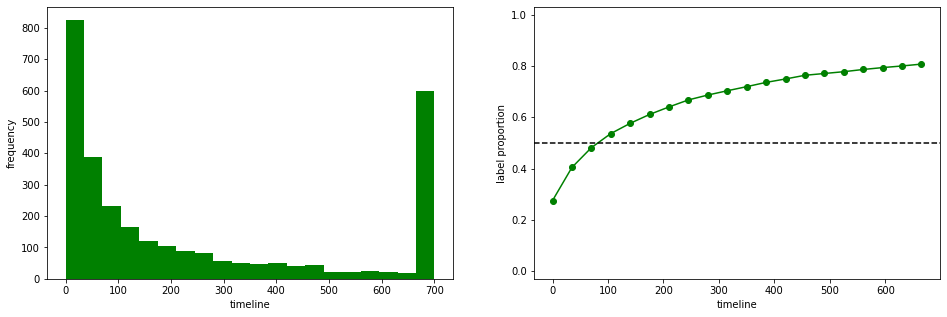

In [9]:
#### PLOT EVENT TARGET AND LABEL PROPORTION

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(y_time, bins=bin_edges, color='green')
plt.xlabel('timeline')
plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.plot(bin_edges[:-1], y_time_ohe.mean(axis=0), marker='o', color='green')
plt.ylim([-0.03, 1.03]); plt.axhline(0.5, linestyle='--', c='black')
plt.xlabel('timeline');plt.ylabel('label proportion')
plt.show()

### MODELING

We start binning the leaving time into groups of regular length (bins). For each customer under analysis, we end up having a normalized categorical target with several unique classes equal to the number of created bins. At this point, we can **transform the target with one hot encoding, resulting in a multidimensional binary target of zeros and ones.** The ones identify in which temporal range our customers are leaving (leaving bins). As the final step, we have to replace, in the target sequences, the zeros with ones on the left before the "leaving bins". This final step is important to provide a temporary path in the target ready to be modeled, where zeros identify the temporal ranges in which our customers are left. 

One hot encoded binned event time (on the left). Cumulative one hot encoded binned event time (on the right).<br> 
<img src="https://miro.medium.com/max/720/1*FpBV-sLrkJuvPo8WoWkhIg.webp">

Now we have all that we need in the correct format. We have a set of features and multidimensional binary target. In other words, we simply have to solve a multidimensional binary classification task. A possibility to solve it consists in using native scikit-learn methodologies. 

In [11]:
### TRAIN TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y_time_ohe, test_size=0.25, shuffle=True, random_state=33 
)

y_test = 1 - y_test

In [12]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

model = ClassifierChain(
    LogisticRegression(random_state=33, max_iter=2000), cv=5
)
model.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(max_iter=2000,
                                                  random_state=33),
                cv=5)

With a classifier chain, **we model our multioutput classification target as standalone but dependent binary classification tasks.** We say dependant since the output of the previous step is concantenated with the initial features and used as input for the next training in the chain. 

After the training phase, we end up with a set of dependent binary classifiers. Each of them provides a probability outcome which is a piece to build the final individual survival curves. The probabilities are for sure between 0 and 1 but there is not guarentee about the monotony constraint proper of survival functions. In other words, **the probability of survival in the first temporal bin must be higher than the ones obtained in the following temporal ranges. To have this requirement satisfied we operate a postprocessing manipulation on the probabilities obtained by our classifier chain at customer levels. 

In [13]:
### Post Processing Survival Curve Predictions
isoreg = IsotonicRegression(y_min=0, y_max=1, increasing=True)
x = np.arange(0, n_bins)

proba = model.predict_proba(X_test)

proba = Parallel(n_jobs=-1, verbose=1)(
    delayed(isoreg.fit_transform)(x,p)
    for p in proba
)

proba = 1 - np.asarray(proba)

proba.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.1s finished


(750, 20)

Simply **applying isotonic regressions on the final probabilities we obtain monotonic survival curves as final outputs.**<br>

Samples of predicted survival curves<br>
<img src="https://miro.medium.com/max/720/0*y8nh28jhFKZg8ud0.webp">

In the end, we can measure the errors like in standard supervised tasks, using our metrics of interest. We may use for example, the Brier Score or the more standard logistic loss. 

In [14]:
from sklearn.metrics import brier_score_loss, log_loss

brier_scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(brier_score_loss)(true, pred, pos_label=1)
    for true, pred in zip(y_test, proba)
)

logloss_scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(log_loss)(true, pred, labels=[0,1])
    for true, pred in zip(y_test, proba)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 747 out of 750 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


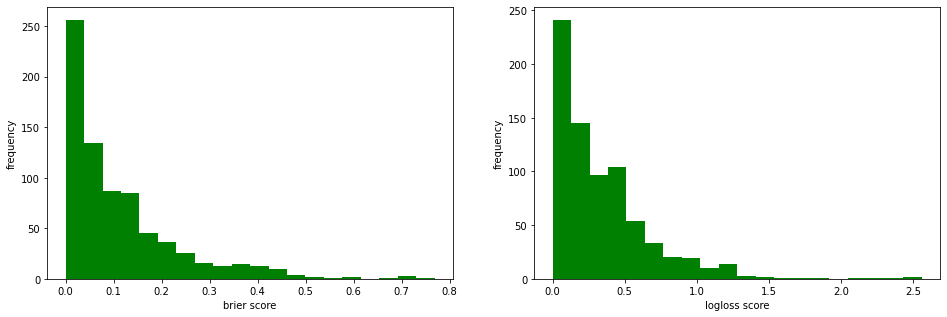

In [15]:
### PLOT TEST SCORE DISTRIBUTIONS

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(brier_scores, bins=20, color='green')
plt.xlabel('brier score'); plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.hist(logloss_scores, bins=20, color='green')
plt.xlabel('logloss score'); plt.ylabel('frequency')
plt.show()

#### SUMMARY

In this post, we introduced a simple and effective method to produce survival curves with standard machine learning classifiers of our choice. We found that we can predict survival curves by modeling the observed failure times as sequence of binary targets. With straightforward probability postprocessing, we obtained reliable probabilistic outputs. The proposed methodology can be easily generalized and applied in a lot of contexts (also considering censored observations if their addition is reasonable to provide a performance improvement). 